# Fokker-Planck 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

> $\partial_t u = \partial_{x}\left(M\partial_{x}\left(\frac{u}{M}\right)\right)$, $t > 0$, $x \in [-5,5]$.

> $u(0, x)=u^0(x), \quad x \in [-5, 5]$

> $\left(\frac{u}{M}\right)_x(t, -5)=\left(\frac{u}{M}\right)_x(t, 5)=0, \quad t \geq 0 .$


## Libraries

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')
sys.path.append('/home/juanfelipe/Desktop/research/kinetick/source')

In [2]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
from numpy.linalg import norm
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Test of `JAX` functionality

In [3]:
T = 2.
T_ = 3.
kernel = Gaussian
params = 1

$\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)|_{x=x_m,y=x_{m'}}$

In [4]:
partial_KoverMx(T,T_,kernel,params)

Array(13.44506721, dtype=float64, weak_type=True)

$M(x)\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)|_{x=x_m,y=x_{m'}}$

In [5]:
MtimesPartialx(T,T_,kernel,params)

Array(1.81959198, dtype=float64, weak_type=True)

$\partial_x\left(M(x)\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)\right)|_{x=x_m,y=x_{m'}}$

In [6]:
T = jnp.array([2.,7.])
T_ = jnp.array([4.,3.,2.])

In [7]:
partial_MtimesPartialx(T,T_,kernel,params)

Array([[ 1.08268227e+00,  1.81959198e+00, -4.44089210e-16],
       [-1.33307958e-01, -4.02555153e-03, -3.72665317e-05]],      dtype=float64)

In [8]:
t = 2.
t_ = 4.
partial_MtimesPartialx_(t,t_,kernel,params)

Array(1.08268227, dtype=float64, weak_type=True)

In [9]:
T = 8.
T_ = 1.
kernel = Gaussian
params = 1

$\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)|_{x=x_m,y=x_{m'}}$

In [10]:
partial_KoverMy(T,T_,kernel,params)

Array(3.02010764e-10, dtype=float64, weak_type=True)

$M(y)\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)|_{x=x_m,y=x_{m'}}$

In [11]:
MtimesPartialy(T,T_,kernel,params)

Array(1.83178788e-10, dtype=float64, weak_type=True)

$\partial_y\left(M(y)\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)\right)|_{x=x_m,y=x_{m'}}$

In [12]:
T = jnp.array([2.,7.])
T_ = jnp.array([4.,3.,2.])

In [13]:
partial_MtimesPartialy(T,T_,kernel,params)

Array([[-5.41341133e-01, -1.21306132e+00, -4.44089210e-16],
       [ 2.33288927e-01,  9.39295358e-03,  1.30432861e-04]],      dtype=float64)

Let's compute the biggest term

In [14]:
t = 2.
t_ = 3.
kernel = Gaussian
params = 1

In [15]:
partialy_partialx_MtimesPartialx_overMy_timesM(t,t_,kernel,params)

Array(6.0653066, dtype=float64, weak_type=True)

In [16]:
T = jnp.array([2.,7.])
T_ = jnp.array([4.,3.,2.])
kernel = Gaussian
params = 1

In [17]:
big_term(T,T_,kernel,params)

Array([[-4.06005850e+00,  3.55271368e-15,  6.00000000e+00],
       [-2.66615917e+00, -1.15734607e-01, -1.43103482e-03]],      dtype=float64)

## Utils

In [18]:
def Kphiphi_assembly(Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern1':
    kernel = Matern_Kernel_1

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param) # K(X,X)
  val2 = partial_MtimesPartialx(Xomega, Xomega, kernel, k_param)
  val3 = partial_MtimesPartialy(Xomega, Xomega, kernel, k_param)
  val4 = big_term(Xomega, Xomega, kernel, k_param)
  val = val1 - h*val2 - h*val3 + (h**2)*val4  
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = MtimesPartialx_(Xomega, Xboundary, kernel, k_param)
  val2 = big_term(Xomega, Xboundary, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = partial_partial(Xboundary, Xboundary, kernel, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [19]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern1':
    kernel = Matern_Kernel_1

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val2 = partial_MtimesPartialx(Xomega, Xtest, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = partial_KoverMx_(Xboundary , Xtest, kernel, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [20]:
# X_full
Xfull = np.linspace(-3,3,102)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = fp_1d_u0(Xomega)
# kernel
kernel = 'Gaussian'
# Kernel lenght-scale
k_param = 0.4
# Time step
h = 1e-2
# Final time - We add 0.1 since that is the initial condition
final_t = h + 0.1 
# nugget
nugget = 1e-8

Build `Kphiphi`

In [21]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)

Build `y_prev`

In [22]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [23]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)

Get `K(Xtest,Xfull)`

In [24]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)

In [25]:
u_next = np.dot(Kphi.T,sol)

In [26]:
np.max(u_next)

0.8980034754410566

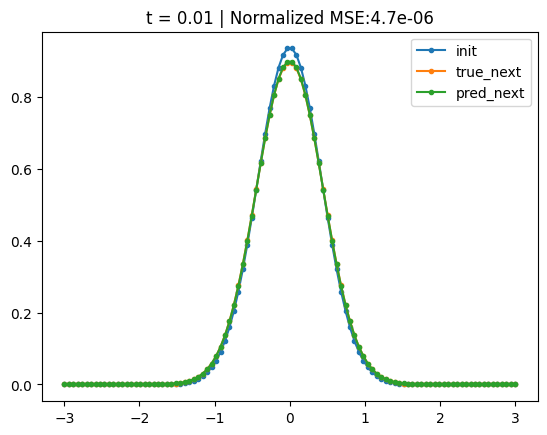

In [27]:
# Initial condition
plt.plot(Xfull,fp_1d_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,fp_1d_sol(final_t, Xfull),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings 
nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [28]:
final_t = 2
steps = int((final_t-0.1)//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

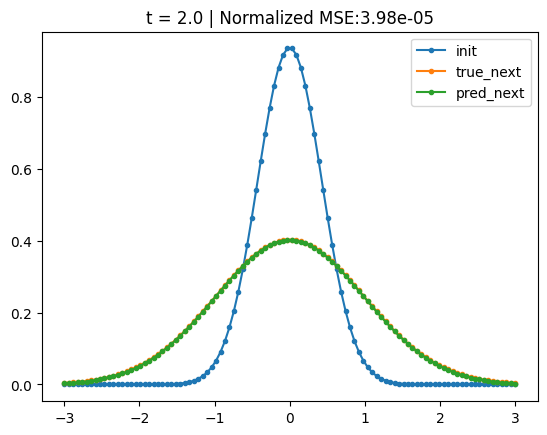

In [29]:
plt.figure()
# Initial condition
plt.plot(Xfull,fp_1d_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,fp_1d_sol(final_t, Xfull),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

## Convergence

In [30]:
nugget = 1e-8

### Experiment 1

- $h = $`1e-1`
- `final_t`$ = 2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [68]:
# Experiment 1.1 - L2-norms
L2_norms_1 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-3,3,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-1
    # Final t
    final_t = 2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.5324876727618107
0.050711132740284194
0.019834032612135993
0.010770787600541874
0.00846082076167257
0.007829873387026348
0.007553056436534189
0.007388194724902328


- $h = $`1e-2`
- `final_t`$ = 2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [69]:
# Experiment 1.2 - L2-norms
L2_norms_2 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-3,3,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-2
    # Final t
    final_t = 2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.5166345356065001
0.008113689967056333
0.0033211720674918184
0.0040563988743190105
0.004396363606597827
0.004477576534277618
0.004515643082157875
0.004540317447820867


- $h = $`1e-3`
- `final_t`$ = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [70]:
# Experiment 1.3 - L2-norms
L2_norms_3 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-3,3,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-3
    # Final t
    final_t = 2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.5031794100090962
0.00709722448325907
0.010364141304231573
0.0131390842638296
0.013560087718181894
0.013678219195068324
0.013726999622191705
0.013753135474821676


- $h = $`1e-4`
- `final_t`$ = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [71]:
# Experiment 1.4 - L2-norms
L2_norms_4 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-3,3,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-4
    # Final t
    final_t = 0.2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.1828280770622641
0.00941776039931099
0.00011406889697645202
4.721652196668687e-05
4.853243463824847e-05
4.788787637497607e-05
4.849691183917188e-05
4.800389490070465e-05


- $h = $`1e-5`
- `final_t`$ = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [72]:
# Experiment 1.5 - L2-norms
L2_norms_5 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-3,3,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-5
    # Final t
    final_t = 0.2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.18269184524656287
0.009102601105920012
0.0002671454664243099
1.1023126764359461e-05
1.2515425872741761e-05
1.4615338477413218e-05
1.7348845760182653e-05
1.7119269842063228e-05


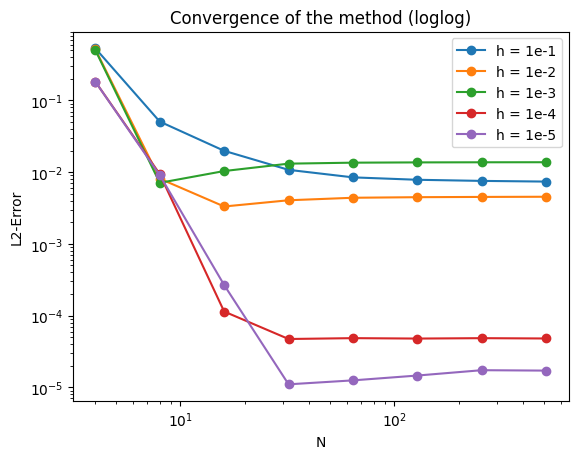

In [73]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'h = 1e-1', marker = 'o')
plt.loglog(xrange,L2_norms_2,label = 'h = 1e-2', marker = 'o')
plt.loglog(xrange,L2_norms_3,label = 'h = 1e-3', marker = 'o')
plt.loglog(xrange,L2_norms_4,label = 'h = 1e-4', marker = 'o')
plt.loglog(xrange,L2_norms_5,label = 'h = 1e-5', marker = 'o')
plt.xlabel('N')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- Try `final_t` = 1 and see what happens for the bigger domain $(-5,5)$ !
- We could check the mass(keeps constant) of the solution since there is no inflow ! 
- Try Matern 2. 
- Is the solution positive ? This implies the mass conservation ! 
- Then go to more dimensions.

Note: Accuracy in space is good. In time, BE is doing ok for our purposes. If we were to use higher order schemes such as RK4 (implicit) we could loose positivity of the solution (which must be since it is a density). Can we prove that the kernel method ensures positivity of the solution ? Probably studying the kernel matrix $K(\phi,\phi)$ ?

## Experiment 2

- $h$ decreasing from `1e-2` to `1e-5`
- $t = 2$
- Collocation points = $2^5$

In [31]:
# Experiment 2.1 - L2-norms
L2_norms_1 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-3,3,2**5+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.0040563988743190105
0.0131390842638296
0.017608363690398473
0.018317756320963104


- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 2$
- Collocation points = $2^6$

In [32]:
# Experiment 2.2 - L2-norms
L2_norms_2 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-3,3,2**6+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.004396363606597827
0.013560087718181894
0.01774060185861434
0.018339293175134393


- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 2$
- Collocation points = $2^7$

In [33]:
# Experiment 2.3 - L2-norms
L2_norms_3 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-3,3,2**7+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.004477576534277618
0.013678219195068324
0.017775337357422667


KeyboardInterrupt: 

- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 2$
- Collocation points = $2^8$

In [ ]:
# Experiment 2.4 - L2-norms
L2_norms_4 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-3,3,2**8+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 2$
- Collocation points = $2^9$

In [ ]:
# Experiment 2.5 - L2-norms
L2_norms_5 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-3,3,2**9+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

In [ ]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'N = 2^5', marker = 'o')
plt.loglog(xrange,L2_norms_2,label = 'N = 2^6', marker = 'o')
plt.loglog(xrange,L2_norms_3,label = 'N = 2^7', marker = 'o')
plt.loglog(xrange,L2_norms_4,label = 'N = 2^8', marker = 'o')
plt.loglog(xrange,L2_norms_5,label = 'N = 2^9', marker = 'o')
plt.xlabel('h')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()